In [15]:
import pandas as pd
import numpy as np
import json
import os
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [16]:
sns.set_palette("colorblind")

In [17]:
def ns_to_ms(ns):
  return ns / 1_000_000

## Data Loading

In [18]:
pwd = "."
figs_dir = "./figs"
!mkdir -p figs

In [19]:
def read_json(path):
  fp = open(path, 'r')
  nb_stats = json.load(fp)
  fp.close()
  return nb_stats

In [27]:
timeDiffThresholdInMs = 200 # ignore cells with time difference less than this (200 ms is an empirical value)
relativeSpeedupThreshold = 1.1 # ignore cells with relative speedup less than this (1.1x is an empirical value)
curFileIndex = 0
filepaths = (
    "aieducation_what-course-are-you-going-to-take",
    "akshaypetkar_supermarket-sales-analysis",
    "ampiiere_animal-crossing-villager-popularity-analysis",
    "arimishabirin_globalsalary-simple-eda",
    "artgor_eda-and-models",
    "beratozmen_clash-of-clans-exploratory-data-analysis",
    "brianmendieta_data-cleaning-plus-eda",
    "carlmcbrideellis_simple-eda-of-kaggle-grandmasters-scheduled",
    "corazzon_how-to-use-pandas-filter-in-survey-eda",
    "dataranch_supermarket-sales-prediction-xgboost-fastai",
    "deffro_eda-is-fun",
    "erikbruin_nlp-on-student-writing-eda",
    "gksriharsha_eda-speedtests",
    "ibtesama_getting-started-with-a-movie-recommendation-system",
    "itzsanju_eda-airline-dataset",
    "jagangupta_stop-the-s-toxic-comments-eda",
    "josecode1_billionaires-statistics-2023",
    "joshuaswords_netflix-data-visualization",
    "jyotsananegi_melbourne-housing-snapshot-eda",
    "kabure_extensive-usa-youtube-eda",
    "kanncaa1_dataiteam-titanic-eda",
    "kenjee_titanic-project-example",
    "khoongweihao_covid-19-novel-coronavirus-eda-forecasting-cases",
    "kimtaehun_simple-preprocessing-for-time-series-prediction",
    "kkhandekar_environmental-vs-ai-startups-india-eda",
    "korfanakis_housing-in-london-eda-with-pandas-and-gif",
    "lextoumbourou_feedback3-eda-hf-custom-trainer-sift",
    "macespinoza_simple-eda-with-python-pandas-data-avocado-paltas",
    "madhurpant_beautiful-kaggle-2022-analysis",
    "madseth_customer-shopping-trends-dataset-eda",
    "mathewvondersaar_analysis-of-student-performance",
    "mikedelong_python-eda-with-kdes",
    "mpwolke_just-you-wait-rishi-sunak",
    "muhammadawaistayyab_used-cars-in-pakistan-stats",
    "natigmamishov_eda-with-pandas-on-telecom-churn-dataset",
    "nickwan_creating-player-stats-using-tracking-data",
    "nicoleashley_iit-admission-eda",
    "paultimothymooney_kaggle-survey-2022-all-results",
    "pmarcelino_comprehensive-data-exploration-with-python",
    "qnqfbqfqo_electric-vehicle-landscape-in-washington-state",
    "robikscube_big-data-bowl-comprehensive-eda-with-pandas",
    "roopacalistus_exploratory-data-analysis-retail-supermarket",
    "roopacalistus_retail-supermarket-store-analysis",
    "roopahegde_cryptocurrency-price-correlation",
    "saisandeepjallepalli_adidas-retail-eda-data-visualization",
    "sandhyakrishnan02_indian-startup-growth-analysis",
    "saniaks_melbourne-house-price-eda",
    "sanket7994_imdb-dataset-eda-project",
    "shivavashishtha_zomato-eda-tutorial",
    "spscientist_student-performance-in-exams",
    "sunnybiswas_eda-on-airline-dataset",
    "tanulsingh077_twitter-sentiment-extaction-analysis-eda-and-model",
    "vanguarde_h-m-eda-first-look",
    "vatsalmavani_music-recommendation-system-using-spotify-dataset",
    "vbmokin_automatic-eda-with-pandas-profiling-2-9-09-2020",
    "viviktpharale_house-price-prediction-eda-linear-ridge-lasso",
    "willkoehrsen_start-here-a-gentle-introduction",
    "xokent_cyber-security-attack-eda",
    "yuliagm_talkingdata-eda-plus-time-patterns",
)

In [986]:
filepath = filepaths[curFileIndex]
curFileIndex += 1
if curFileIndex == len(filepaths):
    curFileIndex = 0
analytical_path = "../../../stats/gcp/nov12/Analytical_Original/" + filepath + ".json"
modin_path = "../../../stats/gcp/nov12/Modin_Original/" + filepath + ".json"
pandas_path = "../../../stats/gcp/nov12/Pandas_Original/" + filepath + ".json"
if os.path.isfile(analytical_path) and os.path.isfile(modin_path) and os.path.isfile(analytical_path):
    print("Go ahead! " + filepath + " exists for all methods")
    analytical_stats = read_json(analytical_path)
    modin_stats = read_json(modin_path)
    pandas_stats = read_json(pandas_path)
else:
    print("Re-run this cell! " + filepath + " does not exist for some methods")

Go ahead! yuliagm_talkingdata-eda-plus-time-patterns exists for all methods


In [987]:
assert len(modin_stats['cells']) == len(pandas_stats['cells']) and len(analytical_stats['cells']) == len(pandas_stats['cells'])
d = {'Code': [], 'Pandas Time': [], 'Modin Time': [], 'Analytical Time': []}
for i in range(len(pandas_stats['cells'])):
  pd_cell = pandas_stats['cells'][i]
  modin_cell = modin_stats['cells'][i]
  analytical_cell = analytical_stats['cells'][i]
  # The cell that imports is different for the pandas and modin versions
  if "import pandas" not in pd_cell['raw']:
    assert pd_cell['raw'] == modin_cell['raw'] and pd_cell['raw'] == analytical_cell['raw']
  d['Code'].append(pd_cell['raw'])
  d['Pandas Time'].append(ns_to_ms(pd_cell['total-ns']))
  d['Modin Time'].append(ns_to_ms(modin_cell['total-ns']))
  d['Analytical Time'].append(ns_to_ms(analytical_cell['total-ns']))

In [988]:
df = pd.DataFrame(d)

## Stats

In [989]:
abs_diff_pm = df['Pandas Time'] - df['Modin Time']
rel_diff_pm = df['Pandas Time'] / df['Modin Time']

abs_diff_pa = df['Pandas Time'] - df['Analytical Time']
rel_diff_pa = df['Pandas Time'] / df['Analytical Time']

abs_diff_ma = df['Modin Time'] - df['Analytical Time']
rel_diff_ma = df['Modin Time'] / df['Analytical Time']

In [990]:
print(str(df['Pandas Time'].sum()/1000)+"\t"+str(df['Modin Time'].sum()/1000)+"\t"+str(df['Analytical Time'].sum()/1000))

27.378613356000006	27.516330174	28.290251844999997


In [991]:
abs_diff_pm[abs_diff_pm > timeDiffThresholdInMs]

Series([], dtype: float64)

In [992]:
rel_diff_pm[rel_diff_pm > relativeSpeedupThreshold]

23    1.136132
31    1.412251
32    1.671916
dtype: float64

<AxesSubplot:xlabel='Notebook index', ylabel='Time (ms)'>

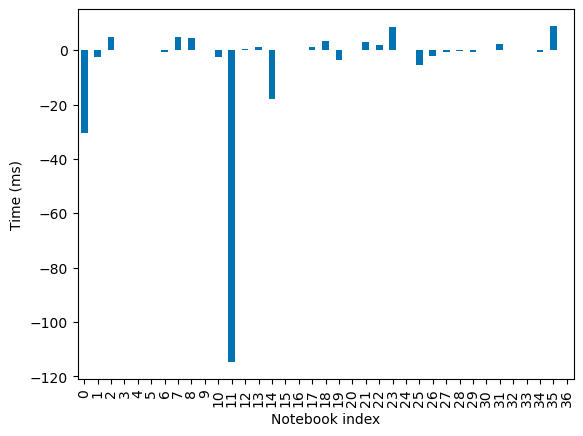

In [993]:
abs_diff_pm.plot(kind='bar', xlabel='Notebook index', ylabel="Time (ms)")

In [994]:
abs_diff_pa[abs_diff_pa > timeDiffThresholdInMs]

Series([], dtype: float64)

In [995]:
rel_diff_pa[rel_diff_pa > relativeSpeedupThreshold]

31    1.399911
32    1.737934
33    1.145332
dtype: float64

<AxesSubplot:xlabel='Notebook index', ylabel='Time (ms)'>

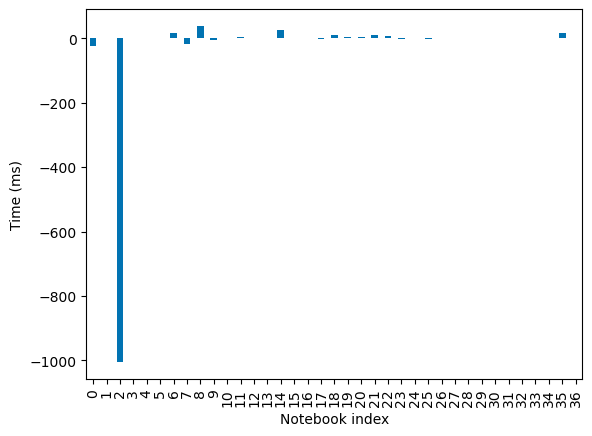

In [996]:
abs_diff_pa.plot(kind='bar', xlabel='Notebook index', ylabel="Time (ms)")

In [928]:
abs_diff_ma[abs_diff_ma > timeDiffThresholdInMs]

0       1517.644457
1       6781.107892
2     258205.651065
3       1466.659577
5        933.833160
8       1996.773457
10      1595.458632
12      1887.423888
13      2566.414300
14     79738.879767
15     19533.427434
16       958.210647
17       714.817333
18      1005.340388
dtype: float64

In [929]:
rel_diff_ma[rel_diff_ma > relativeSpeedupThreshold]

0       1.467269
1       1.250382
2      26.163851
3       2.191576
5      22.396408
8      60.862659
10     16.602275
12      4.782854
13     29.840572
14     32.793679
15    207.300774
16     10.825940
17      8.353576
18      8.310988
19      1.356411
dtype: float64

<AxesSubplot:xlabel='Notebook index', ylabel='Time (ms)'>

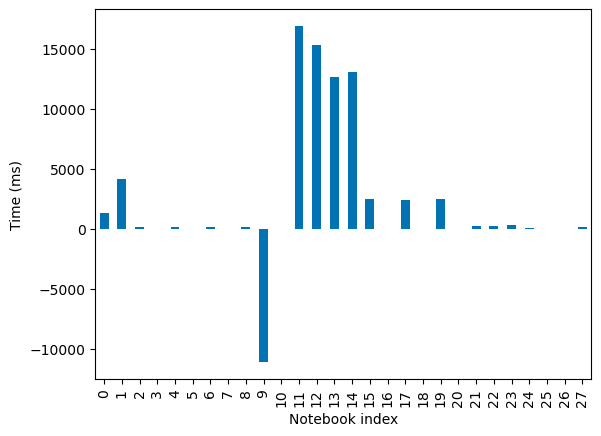

In [890]:
abs_diff_ma.plot(kind='bar', xlabel='Notebook index', ylabel="Time (ms)")

In [976]:
# If we want to check the code of a notebook
print(49)
print(df.iloc[48]['Code'])

print(7)
print(df.iloc[6]['Code'])

print(12)
print(df.iloc[11]['Code'])

49
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

# random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
7
app_train['TARGET'].astype(int)
12
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.tra